# Auto correlation (ACF, PACF), Auto Regressive Models

### Revisão
- Detecção de Tendência e Sazonalidade
    - Exploração Visual
    - Decomposição de Séries Temporais (HP-Filter e STL)
- Estacionariedade (Conceito e testes)
- Alisamento Exponencial (Simples, Duplo e Triplo)
- Introdução ao operador lag e auto correlação
### Hoje
- Revisão 
- Slide de intro aos modelos ARIMA/ARIMAX/SARIMAX
- Operador Lag
- Intro aos modelos AR
- Transformações para atingir estacionariedade
- ACF e PACF
- Ajuste de Modelos AR
- Modelos ARI

### Preparação


In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.datasets import co2, get_rdataset
plt.rcParams["figure.figsize"] = [10, 3]

In [97]:
# Co2 (Tendência e Sazonalidade Aditiva)
co2_df = co2.load_pandas().data
co2_s = pd.Series(co2_df['co2'].ffill().resample('MS').mean(), name='Mauna Loa CO2')
# Air Passenger (Tendência e Sazonalidade Multiplicativa)
air_passengers = get_rdataset("AirPassengers").data
air_passengers.index = pd.date_range('1949', '1960-12', freq='MS')
airp_s = pd.Series(air_passengers['value'], name = 'Número de Passageiros')
# Séries com ações
file = Path('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/closing_price.csv')
closing_price = pd.read_csv(file, index_col='Date',parse_dates=True).resample('MS').mean()
apple = pd.Series(closing_price['AAPL'], name='Preço de Fechamento Apple')
microsoft = pd.Series(closing_price['MSFT'], name='Preço de Fechamento Microsoft')
ibm = pd.Series(closing_price['IBM'], name='Preço de Fechamento IBM')
# Lancamentos Netflix
netf = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/netflix_titles.csv')
netf.index = pd.to_datetime(netf['date_added'], format='%B %d, %Y', errors = 'coerce')
lancamentos = netf.resample('MS').size()
netflix = pd.Series(lancamentos[lancamentos.index.year>2015],name='Lançamentos Netflix desde 2016')
todas_series = [co2_s,airp_s,apple,microsoft,ibm, netflix]

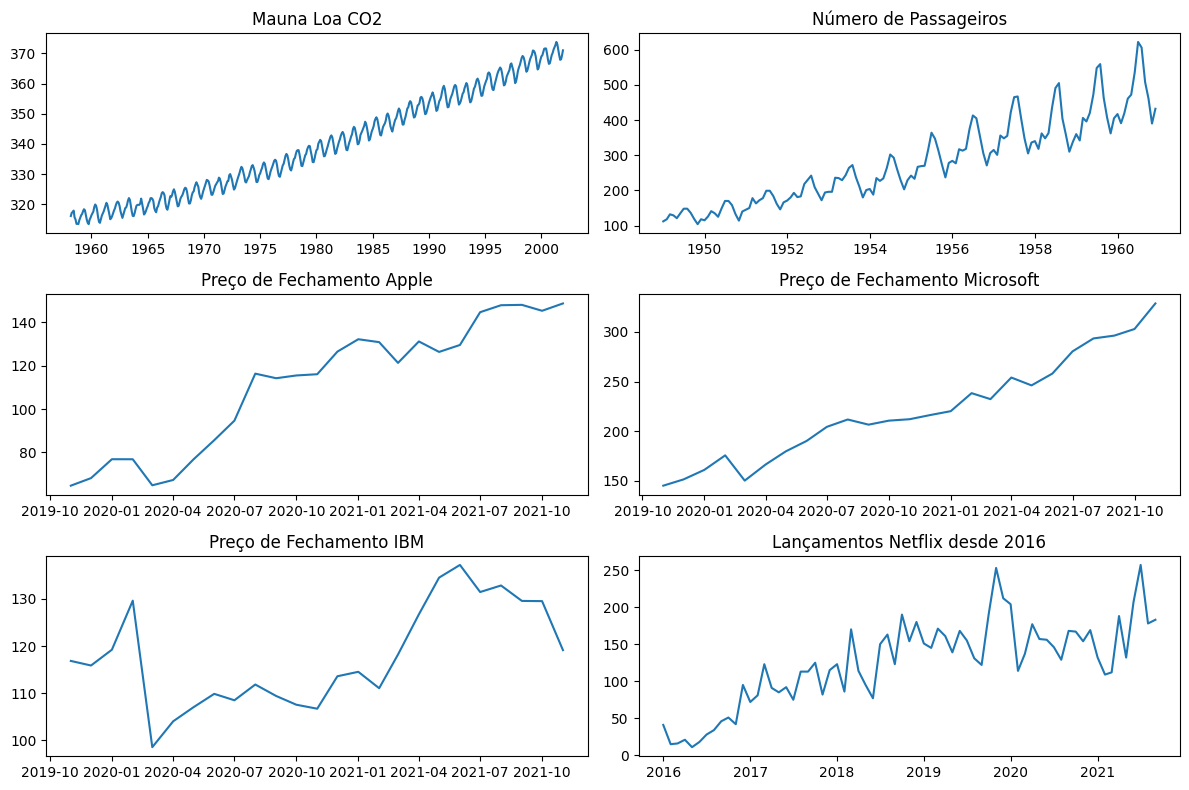

In [98]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axes = axes.flatten()
for i,s in enumerate(todas_series):
    ax = axes[i]
    ax.plot(s)
    ax.set_title(s.name)
plt.tight_layout()
plt.show()

### - SARIMAX: Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors.
### - Operador Lag
O operador lag (também conhecido como operador backshift ) é uma função que desloca uma série temporal de forma que os valores “lagged estejam alinhados com a série temporal real. Os lags podem ser calculados para qualquer número de unidades, o que simplesmente controla a duração do retrocesso/backshift .

In [99]:
np.random.seed(42)
y = pd.Series(np.random.randint(0, 20, size=10), index=pd.date_range(start='2025-01-01', periods=10))
y


2025-01-01     6
2025-01-02    19
2025-01-03    14
2025-01-04    10
2025-01-05     7
2025-01-06     6
2025-01-07    18
2025-01-08    10
2025-01-09    10
2025-01-10     3
Freq: D, dtype: int64

In [100]:
y.shift(1)

2025-01-01     NaN
2025-01-02     6.0
2025-01-03    19.0
2025-01-04    14.0
2025-01-05    10.0
2025-01-06     7.0
2025-01-07     6.0
2025-01-08    18.0
2025-01-09    10.0
2025-01-10    10.0
Freq: D, dtype: float64

In [101]:
df = pd.DataFrame({'Y':y, 'Yminus1': y.shift(1), 'Yminus2': y.shift(2), 'Yminus3': y.shift(3), 'Yminus4': y.shift(4)})
df


,Y,Yminus1,Yminus2,Yminus3,Yminus4
2025-01-01,6,NaN,NaN,NaN,NaN
2025-01-02,19,6.0,NaN,NaN,NaN
2025-01-03,14,19.0,6.0,NaN,NaN
2025-01-04,10,14.0,19.0,6.0,NaN
2025-01-05,7,10.0,14.0,19.0,6.0
2025-01-06,6,7.0,10.0,14.0,19.0
2025-01-07,18,6.0,7.0,10.0,14.0
2025-01-08,10,18.0,6.0,7.0,10.0
2025-01-09,10,10.0,18.0,6.0,7.0
2025-01-10,3,10.0,10.0,18.0,6.0


### - Intro aos modelos AR

In [102]:
df = pd.DataFrame({'Y':y, 'X1': y.shift(1), 'X2': y.shift(2), 'X3': y.shift(3), 'X4': y.shift(4)})
df

,Y,X1,X2,X3,X4
2025-01-01,6,NaN,NaN,NaN,NaN
2025-01-02,19,6.0,NaN,NaN,NaN
2025-01-03,14,19.0,6.0,NaN,NaN
2025-01-04,10,14.0,19.0,6.0,NaN
2025-01-05,7,10.0,14.0,19.0,6.0
2025-01-06,6,7.0,10.0,14.0,19.0
2025-01-07,18,6.0,7.0,10.0,14.0
2025-01-08,10,18.0,6.0,7.0,10.0
2025-01-09,10,10.0,18.0,6.0,7.0
2025-01-10,3,10.0,10.0,18.0,6.0


Suposições:
- Linearidade: A relação entre o valor atual e seus valores passados é linear.
- Estacionariedade: A série temporal possui média, variância e autocorrelação constantes ao longo do tempo.
- Ausência de Multicolinearidade: Os valores passados (defasagens) usados como preditores não são altamente correlacionados entre si.
- Erros de Ruído Branco: Os resíduos (erros) são distribuídos normalmente com média zero e variância constante (homocedasticidade).
- Ausência de Autocorrelação nos Erros: Os resíduos não são autocorrelacionados, ou seja, não há padrão nos erros ao longo do tempo.

In [103]:
from statsmodels.tsa.stattools import adfuller, kpss

def teste_estacionariedade(s):
    kps = kpss(s)
    adf = adfuller(s)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Estacionário', 'Não Estacionário'
    
    if adf_pv < 0.05:
        adfh = 'Estacionário'
    if kpss_pv < 0.05:
        kpssh = 'Não Estacionário'
    return (kpssh, adfh)

def mostra_series_com_testes(series, n_rows, n_cols,figsize=(12, 8)):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()
    for i,s in enumerate(series):
        ax = axes[i]
        ax.plot(s)
        ax.set_title(f'{s.name} - KPSS: {teste_estacionariedade(s)[0]} ADF: {teste_estacionariedade(s)[1]}', fontsize=10)
    plt.tight_layout()
    plt.show()


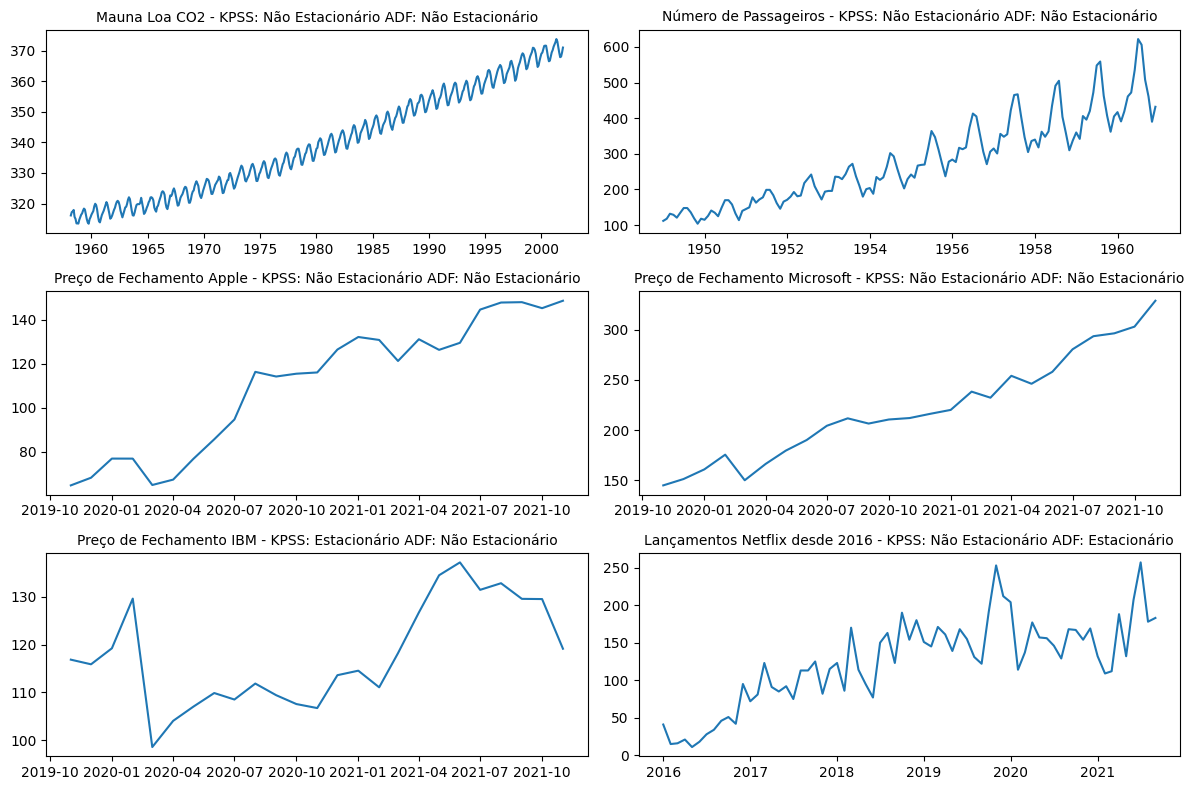

In [104]:
mostra_series_com_testes(todas_series,3,2)

## Transformações para atingir estacionariedade

- Diferenciação
    - Primeira Ordem
    - Segunda Ordem
    - Sazonal
- Log(Diferença Percentual)

### Diff Primeira Ordem

$$ \large y'_t = y_t - y_{t-1}  $$

In [105]:
serie_original = co2_s
primeira_ordem = serie_original.diff().dropna()
primeira_ordem

1958-04-01    1.100
1958-05-01    0.220
1958-06-01    0.480
1958-07-01   -2.275
1958-08-01   -0.665
              ...  
2001-08-01   -1.875
2001-09-01   -1.545
2001-10-01    0.170
2001-11-01    1.325
2001-12-01    1.645
Freq: MS, Name: Mauna Loa CO2, Length: 525, dtype: float64

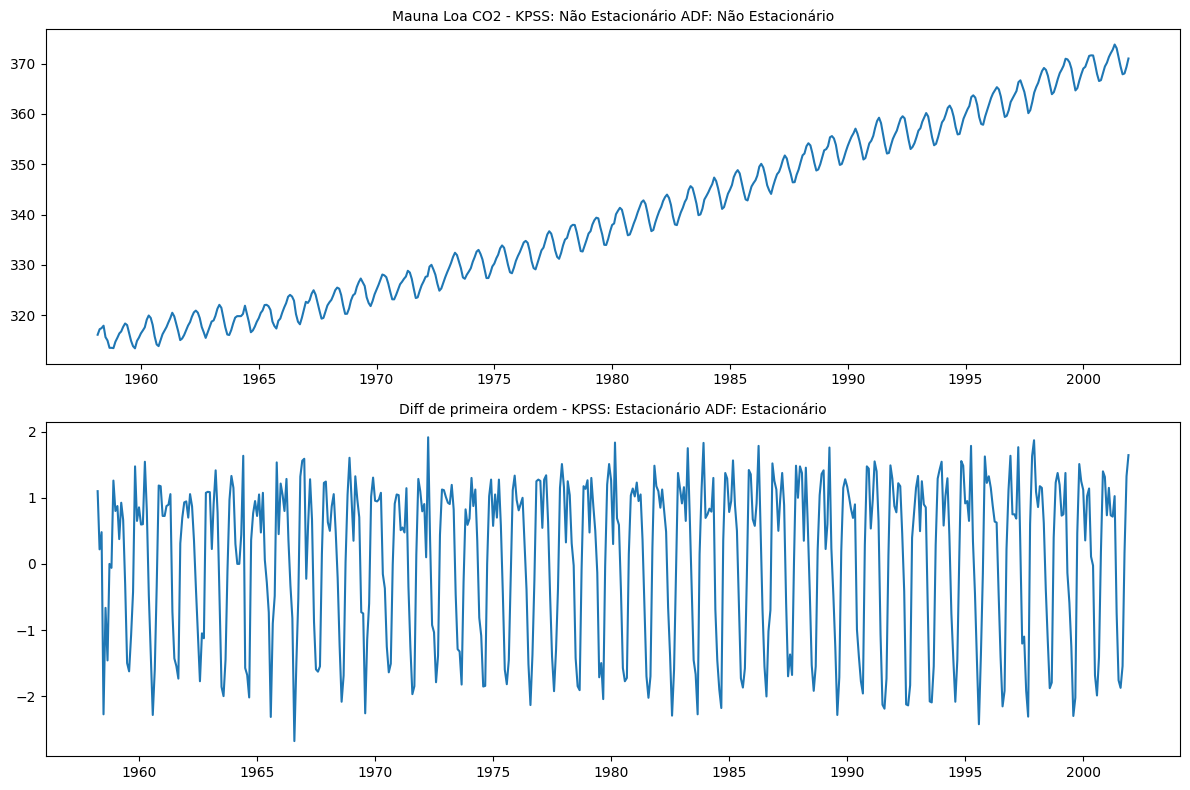

In [106]:
primeira_ordem = pd.Series(primeira_ordem, name = 'Diff de primeira ordem')
series = [serie_original, primeira_ordem]
mostra_series_com_testes(series,2,1)

### Diff Segunda Ordem
$$ \large y'_t = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) $$

In [107]:
segunda_ordem = serie_original.diff().diff().dropna()
segunda_ordem = pd.Series(segunda_ordem, name = 'Diff de segunda ordem')

### Diff Sazonal
$$ \large y'_t = y_t - y_{t-12} $$


In [108]:
diff_sazonal = serie_original.diff(12).dropna()
diff_sazonal = pd.Series(diff_sazonal, name = 'Diff Sazonal')

### log diff

$$ \large y'_t = \log(y_t) - \log(y_{t-1}) = \log\left(\frac{y_t}{y_{t-1}}\right) $$

In [109]:
log_diff = np.log(serie_original/serie_original.shift(1)).dropna()
log_diff = pd.Series(log_diff, name = 'Diferença logarítmica')

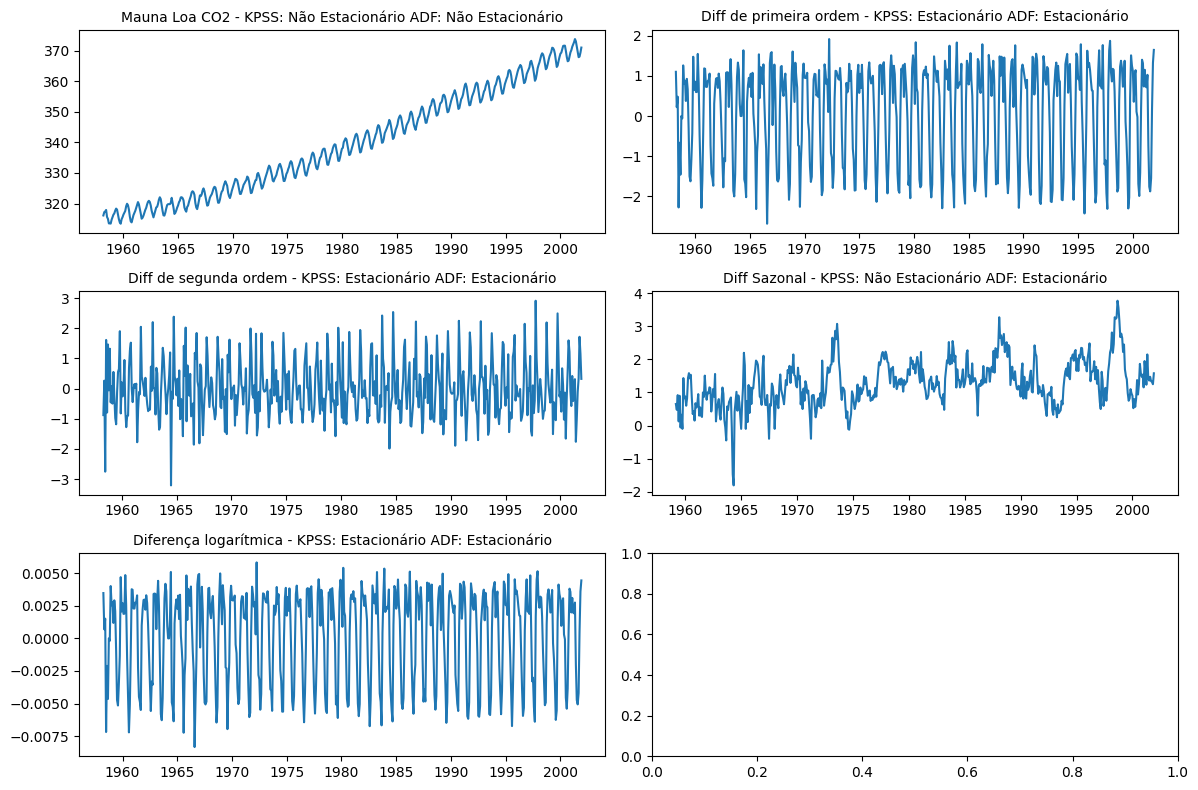

In [134]:
series = [serie_original, primeira_ordem, segunda_ordem, diff_sazonal, log_diff]
mostra_series_com_testes(series,3,2)

### Box-Cox
$$ \large y_t^{(\lambda)} =
\begin{cases}
\frac{y_t^\lambda - 1}{\lambda}, & \lambda \neq 0 \\
\log(y_t), & \lambda = 0
\end{cases} $$


In [132]:
from scipy.stats import boxcox
boxcox_transform, lmbda = boxcox(serie_original)
boxcox_transform = pd.Series(boxcox_transform, index = serie_original.index, name = 'Box-Cox')

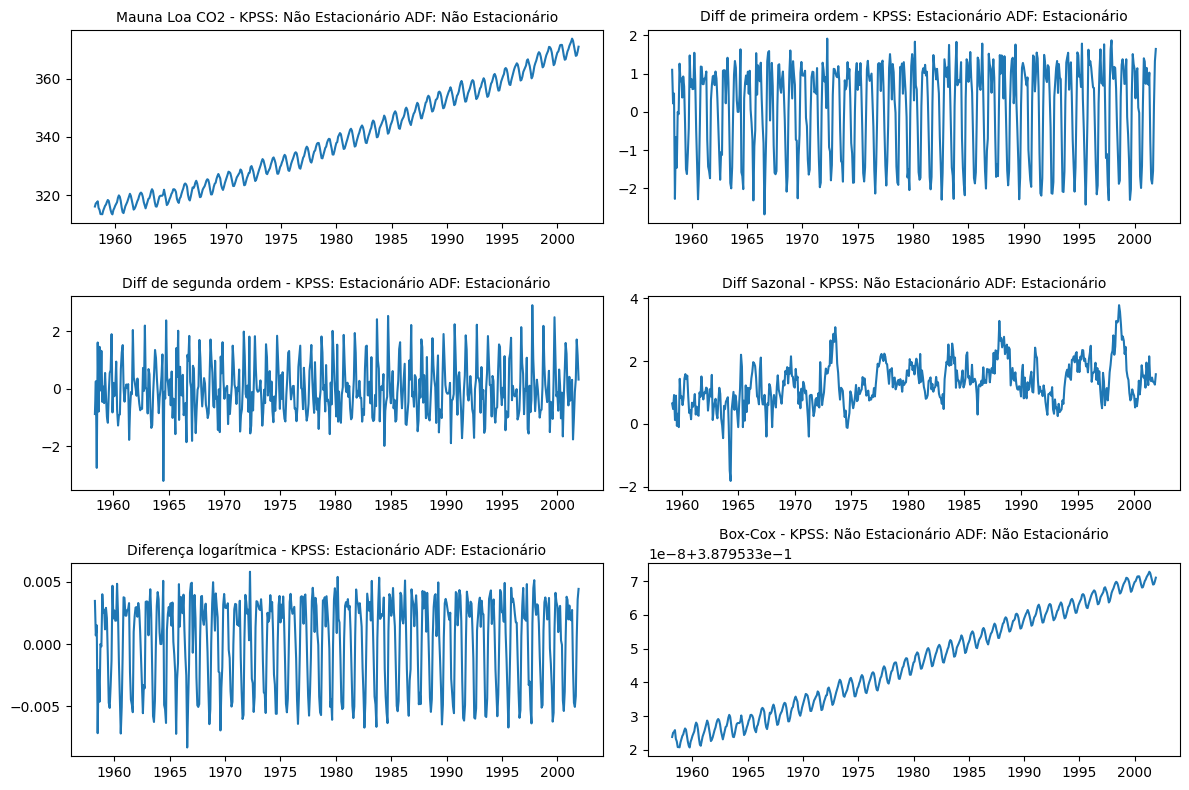

In [133]:
series = [serie_original, primeira_ordem, segunda_ordem, diff_sazonal, log_diff, boxcox_transform]
mostra_series_com_testes(series,3,2)

In [ ]:
serie = co2_s

# using first order differencing (detrending)
first_ord_diff = serie.diff().dropna()

# using second order differencing
second_ord_diff = serie.diff().diff().dropna()

# differencing to remove seasonality
diseasonalize = serie.diff(12).dropna()

# using rolling mean 
rolling_mean = serie.rolling(window=12).mean()
subt_roll_mean = serie - rolling_mean

# log transform
log_transform = np.log(serie)

# Square root transform
square_root = np.sqrt(serie)

# using seasonal_decompose to remove trend
decomp = seasonal_decompose(serie)
sd_detrend = (decomp.observed - decomp.trend)

# using hp_filter 
cyclic_extract, trend = hpfilter(serie)

# combine the methods into a list
methods = [first_ord_diff, second_ord_diff, 
           diseasonalize, subt_roll_mean, 
           log_transform, square_root,
           sd_detrend, cyclic_extract]

warnings.simplefilter(action='ignore')
plot = plot_comparison(methods)

NameError: name 'plot_comparison' is not defined

Quando você decide tirar a tendência dos dados você está removendo um elemento de distração, para você poder focar em padrões escondidos nos dados.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, boxcox
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_goldfeldquandt, 
                                   het_white, jarque_bera,
                                   omni_normtest, normal_ad)
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant

In [ ]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

In [ ]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [ ]:
normal_args = (np.mean(co2_df),np.std(co2_df))

print(is_normal(shapiro(co2_df)))
print(is_normal(normaltest(co2_df)))
print(is_normal(normal_ad(co2_df)))
print(is_normal(kstest_normal(co2_df)))
print(is_normal(kstest(co2_df, 
                   cdf='norm', 
                   args=normal_args)))

Not Normal
Not Normal
Not Normal
Not Normal
Not Normal


array([[<Axes: title={'center': 'co2'}>]], dtype=object)

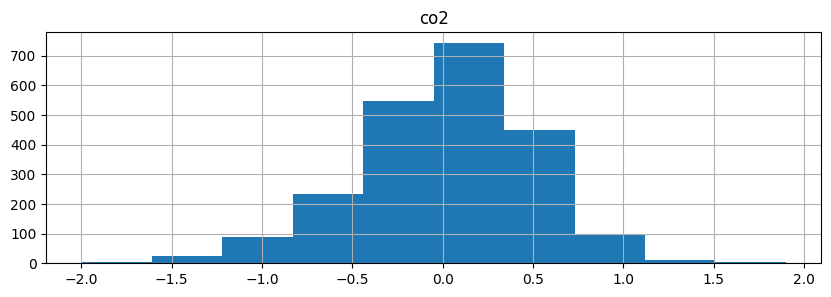

In [ ]:
co2_df.diff().hist()

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(co2_df.dropna(), lags=1, trend='n').fit()

In [ ]:
print(is_normal(shapiro(model.resid)))
print(is_normal(normaltest(model.resid)))
print(is_normal(normal_ad(model.resid)))
print(is_normal(kstest_normal(model.resid)))
print(is_normal(kstest(model.resid, 
                   cdf='norm', 
                   args=(np.mean(model.resid), np.std(model.resid)))))

Not Normal
Not Normal
Not Normal
Not Normal
Not Normal


(array([  6.,  25.,  89., 365., 592., 721., 380.,  37.,   5.,   4.]),
 array([-2.12312816, -1.69314199, -1.26315581, -0.83316963, -0.40318346,
         0.02680272,  0.4567889 ,  0.88677507,  1.31676125,  1.74674743,
         2.17673361]),
 <BarContainer object of 10 artists>)

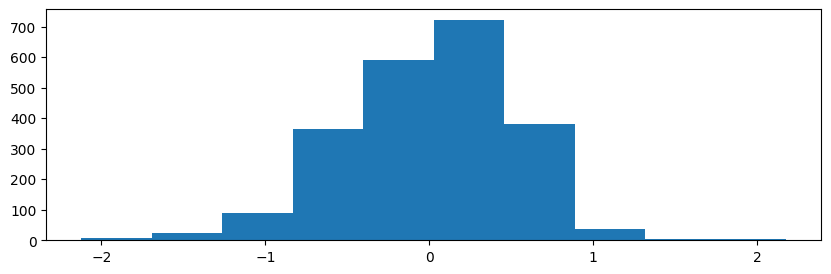

In [ ]:
plt.hist(model.resid)

In [ ]:

model.resid.mean()

np.float64(0.00016474445105614212)

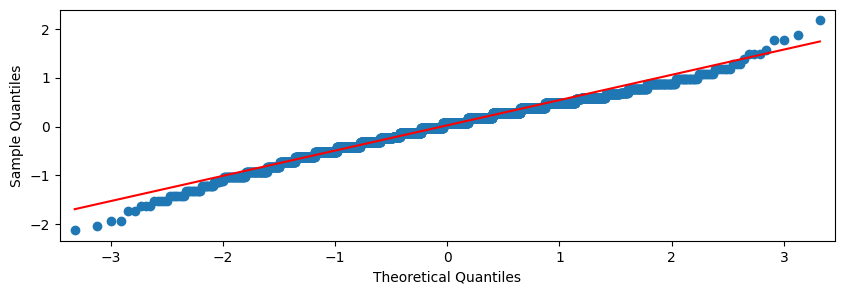

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(model.resid, line='q');

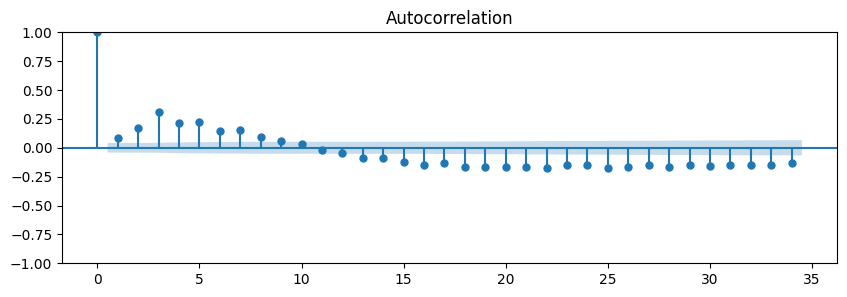

In [ ]:
plot_acf(model.resid);plt.show()

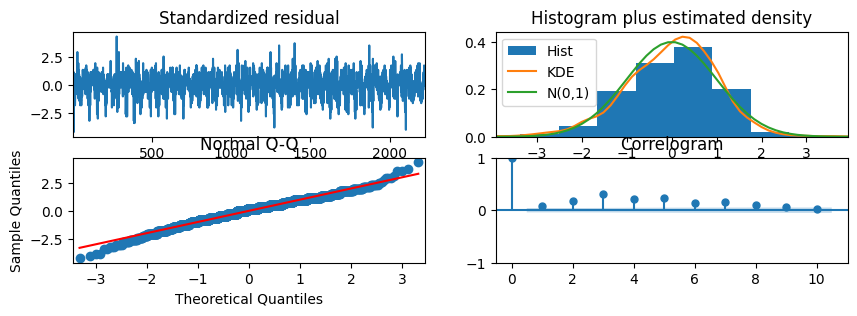

In [ ]:
model.plot_diagnostics();plt.show()

In [ ]:
model.test_normality()

Jarque-Bera    1.008372e+02
P-value        1.269039e-22
Skewness      -3.388130e-01
Kurtosis       3.793092e+00
dtype: float64

In [ ]:
model.test_heteroskedasticity()

,ARCH-LM,P-value,DF
Lag,,,
1,0.564015,0.452647,1
2,4.197137,0.122632,2
3,29.248823,0.000002,3
4,29.145150,0.000007,4
5,32.231338,0.000005,5
6,32.977406,0.000011,6
7,35.082803,0.000011,7
8,34.999316,0.000027,8
9,35.084646,0.000058,9


In [ ]:
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_white)

In [ ]:
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        het_breuschpagan(model.resid, 
                         add_constant(
                             model.fittedvalues)
                        ))
    
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"

In [ ]:
het_test(model, test=het_breuschpagan)

'Homoskedastic'

In [ ]:
het_test(model, test=het_white)

'Homoskedastic'

In [ ]:
from scipy.stats import boxcox

In [ ]:
xt, lmbda = boxcox(airp_s)

NameError: name 'boxcox' is not defined

In [ ]:
xts = pd.Series(xt, index=airp_df.index)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
airp_df.hist(ax=ax[0])
ax[0].set_title('Original Time Series')
xts.hist(ax=ax[1])
ax[1].set_title('Box-Cox Transformed')
plt.savefig('images/fig_9.23.png', bbox_inches='tight')

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(16,5))
airp_df.plot(ax=ax[0])
ax[0].set_title('Original Time Series')
xts.plot(ax=ax[1])
ax[1].set_title('Box-Cox Transformed')
#plt.savefig('images/fig_9.24.png', bbox_inches='tight')

In [ ]:
model_airp = AutoReg(airp_df, lags=1, trend='n').fit()
model_bx = AutoReg(xts, lags=1, trend='n').fit()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
model_airp.resid.plot(ax=ax[0])
ax[0].set_title('Residuals Plot - Regular Time Series')
model_bx.resid.plot(ax=ax[1])
ax[1].set_title('Residual Plot - Box-Cox Transformed')
#plt.savefig('images/fig_9.25.png', bbox_inches='tight')